Toronto Daily Shelter Overnight Occupacny

## Summary

This summary pertains to a dataset focused on the daily activities and statistics of overnight shelters and related services within the Toronto Shelter and Support Services division. The data, sourced from the Shelter Management Information System (SMIS), offers detailed daily updates on various aspects of shelter services including operations, locations, classifications, occupancy rates, and capacity details since 2021. Key columns such as 'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_MODEL', 'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'OCCUPANCY_RATE_BEDS', and 'LOCATION_NAME' are primarily utilized for analysis, with their detailed descriptions available on the dataset's webpage. https://open.toronto.ca/dataset/daily-shelter-overnight-service-occupancy-capacity/

The primary objective of analyzing this dataset is to identify which factors significantly influence the bed capacity in shelters, through comprehensive data cleaning to remove incomplete records and conducting exploratory data analysis (EDA). The data exhibited high levels of skewness, prompting the application of logarithmic and Box-Cox transformations to achieve normalization, especially after preliminary hypothesis testing showed the data were not normally distributed.

## Supervised Machine Learning Model

### Section 1
Reading Data
- Pandas
- Pandas.read_sql
- SQLite3

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Statistics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression


# Database
import sqlite3 as sq3
import pandas.io.sql as pds

# Configuration to suppress warnings and enhance plot quality
import warnings
warnings.warn = lambda *args, **kwargs: None  # Suppress all warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_formats = ['retina']  # High-resolution plots


In [2]:
np.random.seed(72018)


def to_2d(array):
    return array.reshape(array.shape[0], -1)
    
def plot_exponential_data():
    data = np.exp(np.random.normal(size=1000))
    plt.hist(data)
    plt.show()
    return data
    
def plot_square_normal_data():
    data = np.square(np.random.normal(loc=5, size=1000))
    plt.hist(data)
    plt.show()
    return data

In [3]:
# Combine different years data to one dataset
# List of file paths
file_paths = [
    '/Users/hslee/ML Project/IBM_Certification/2. Supervised Model/Course Capstone/Data/Daily shelter overnight occupancy.csv',
    '/Users/hslee/ML Project/IBM_Certification/2. Supervised Model/Course Capstone/Data/daily-shelter-overnight-service-occupancy-capacity-2023.csv',
    '/Users/hslee/ML Project/IBM_Certification/2. Supervised Model/Course Capstone/Data/daily-shelter-overnight-service-occupancy-capacity-2022.csv',
    '/Users/hslee/ML Project/IBM_Certification/2. Supervised Model/Course Capstone/Data/daily-shelter-overnight-service-occupancy-capacity-2021.csv'
]

# List to store the columns of each file
columns_list = []

# Read and store the columns of each file
for file_path in file_paths:
    df_temp = pd.read_csv(file_path, nrows=0)  # Only read columns without data
    columns_list.append(df_temp.columns.tolist())

# Check if all files have the same columns
if all(columns_list[0] == columns for columns in columns_list):
    # If columns are the same, combine all files
    df_combined = pd.concat([pd.read_csv(fp) for fp in file_paths], ignore_index=True)
    print("All files have the same columns. Combined DataFrame created.")
else:
    print("Files have different columns. Please check the column names.")

# Check the combined data (if columns are the same)
if 'df_combined' in locals():
    print(df_combined.head())
else:
    print("DataFrame not created due to column discrepancies.")


All files have the same columns. Combined DataFrame created.
   _id OCCUPANCY_DATE  ORGANIZATION_ID         ORGANIZATION_NAME  SHELTER_ID  \
0    1     2024-01-01               24  COSTI Immigrant Services          40   
1    2     2024-01-01               24  COSTI Immigrant Services          40   
2    3     2024-01-01               24  COSTI Immigrant Services          40   
3    4     2024-01-01               24  COSTI Immigrant Services          40   
4    5     2024-01-01               24  COSTI Immigrant Services          40   

            SHELTER_GROUP  LOCATION_ID               LOCATION_NAME  \
0  COSTI Reception Centre       1320.0   COSTI Hotel Program Dixon   
1  COSTI Reception Centre       1320.0   COSTI Hotel Program Dixon   
2  COSTI Reception Centre       1051.0      COSTI Reception Centre   
3  COSTI Reception Centre       1114.0  COSTI Uptown Hotel Program   
4  COSTI Reception Centre       1114.0  COSTI Uptown Hotel Program   

    LOCATION_ADDRESS LOCATION_POSTAL_

In [4]:
df = df_combined[df_combined['LOCATION_CITY'] == 'Toronto']


In [5]:
df.head()

,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,...,OCCUPIED_BEDS,UNOCCUPIED_BEDS,UNAVAILABLE_BEDS,CAPACITY_ACTUAL_ROOM,CAPACITY_FUNDING_ROOM,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS
0,1,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,...,NaN,NaN,NaN,149.0,150.0,149.0,0.0,1.0,NaN,100.0
1,2,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,...,NaN,NaN,NaN,57.0,57.0,57.0,0.0,0.0,NaN,100.0
2,3,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1051.0,COSTI Reception Centre,100 Lippincott St,M5S 2P1,...,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN
6,7,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1172.0,CONC West End Hotel Program,14 Roncesvalles Ave,M6R 2K3,...,NaN,NaN,NaN,39.0,41.0,39.0,0.0,2.0,NaN,100.0
7,8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,...,42.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN


## Data Cleaning


In [6]:
print(df.shape[0])
print(df.columns.tolist())
print(df.dtypes)


120647
['_id', 'OCCUPANCY_DATE', 'ORGANIZATION_ID', 'ORGANIZATION_NAME', 'SHELTER_ID', 'SHELTER_GROUP', 'LOCATION_ID', 'LOCATION_NAME', 'LOCATION_ADDRESS', 'LOCATION_POSTAL_CODE', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_ID', 'PROGRAM_NAME', 'SECTOR', 'PROGRAM_MODEL', 'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA', 'SERVICE_USER_COUNT', 'CAPACITY_TYPE', 'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS', 'CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS', 'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS']
_id                         int64
OCCUPANCY_DATE             object
ORGANIZATION_ID             int64
ORGANIZATION_NAME          object
SHELTER_ID                  int64
SHELTER_GROUP              object
LOCATION_ID               float64
LOCATION_NAME              object
LOCATION_ADDRESS           object
LOCATION_POSTAL_CODE       object
LOCATION_CITY              object
LOCATION_PRO

In [7]:
# Convert the OCCUPANCY_DATE column to a datetime object
df['OCCUPANCY_DATE'] = pd.to_datetime(df['OCCUPANCY_DATE'])

# Check the data type of the converted column
print(df.dtypes)


_id                                int64
OCCUPANCY_DATE            datetime64[ns]
ORGANIZATION_ID                    int64
ORGANIZATION_NAME                 object
SHELTER_ID                         int64
SHELTER_GROUP                     object
LOCATION_ID                      float64
LOCATION_NAME                     object
LOCATION_ADDRESS                  object
LOCATION_POSTAL_CODE              object
LOCATION_CITY                     object
LOCATION_PROVINCE                 object
PROGRAM_ID                         int64
PROGRAM_NAME                      object
SECTOR                            object
PROGRAM_MODEL                     object
OVERNIGHT_SERVICE_TYPE            object
PROGRAM_AREA                      object
SERVICE_USER_COUNT                 int64
CAPACITY_TYPE                     object
CAPACITY_ACTUAL_BED              float64
CAPACITY_FUNDING_BED             float64
OCCUPIED_BEDS                    float64
UNOCCUPIED_BEDS                  float64
UNAVAILABLE_BEDS

In [8]:
df_filtered = df.copy()

In [9]:
df_filtered = df_filtered[[
    'OVERNIGHT_SERVICE_TYPE', 'CAPACITY_TYPE', 'PROGRAM_MODEL',
    'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED',
    'CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM',
    'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS',
    'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS',
    'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS',
    'LOCATION_ID', 'LOCATION_NAME'
]]


In [10]:
missing_values = df_filtered.isnull().sum()
missing_values

OVERNIGHT_SERVICE_TYPE        2
CAPACITY_TYPE                 0
PROGRAM_MODEL                 2
CAPACITY_ACTUAL_BED       30544
CAPACITY_FUNDING_BED      30544
CAPACITY_ACTUAL_ROOM      90103
CAPACITY_FUNDING_ROOM     90273
OCCUPIED_BEDS             30544
UNOCCUPIED_BEDS           30544
OCCUPIED_ROOMS            90103
UNOCCUPIED_ROOMS          90103
OCCUPANCY_RATE_BEDS       30544
OCCUPANCY_RATE_ROOMS      90103
LOCATION_ID                   0
LOCATION_NAME                 2
dtype: int64

In [11]:
# Use only the bed, not room because it has too many null data

df_filtered = df_filtered[[
    'OVERNIGHT_SERVICE_TYPE', 'CAPACITY_TYPE', 'PROGRAM_MODEL',
    'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED',
    'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS',
    'OCCUPANCY_RATE_BEDS', 
    'LOCATION_ID', 'LOCATION_NAME'
]]

In [12]:
# List of columns of interest
columns_to_fill = [
    'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED',
    'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'OCCUPANCY_RATE_BEDS'
]

# Calculate the median for each column by LOCATION_ID and fill missing values
for column in columns_to_fill:
    # Calculate the median of the column by LOCATION_ID
    median_value = df_filtered.groupby('LOCATION_ID')[column].transform('median')
    
    # Fill missing values with the median
    df_filtered[column].fillna(median_value, inplace=True)


In [13]:
df_filtered_check = df_filtered.isnull().sum()
df_filtered_check

OVERNIGHT_SERVICE_TYPE        2
CAPACITY_TYPE                 0
PROGRAM_MODEL                 2
CAPACITY_ACTUAL_BED       23242
CAPACITY_FUNDING_BED      23242
OCCUPIED_BEDS             23242
UNOCCUPIED_BEDS           23242
OCCUPANCY_RATE_BEDS       23242
LOCATION_ID                   0
LOCATION_NAME                 2
dtype: int64

In [14]:

columns_to_check = [
    'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_MODEL', 'CAPACITY_ACTUAL_BED',
    'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS',
    'OCCUPANCY_RATE_BEDS', 'LOCATION_NAME'
]

df_cleaned = df_filtered.dropna(subset=columns_to_check)


print(f"Original data rows: {df_filtered.shape[0]}, After removing nulls: {df_cleaned.shape[0]}")


Original data rows: 120647, After removing nulls: 97403


In [15]:
df_c = df_cleaned.copy()

## EDA

In [16]:
df_c.describe().T


,count,mean,std,min,25%,50%,75%,max
CAPACITY_ACTUAL_BED,97403.0,35.825950,30.944565,1.0,17.00,28.0,49.0,264.0
CAPACITY_FUNDING_BED,97403.0,37.505457,32.121551,2.0,19.00,28.0,50.0,264.0
OCCUPIED_BEDS,97403.0,34.924510,30.940887,1.0,16.00,27.0,47.0,264.0
UNOCCUPIED_BEDS,97403.0,0.889695,2.385509,0.0,0.00,0.0,1.0,53.0
OCCUPANCY_RATE_BEDS,97403.0,95.855613,9.651504,2.0,96.43,100.0,100.0,100.0
LOCATION_ID,97403.0,1082.659774,76.122999,1002.0,1022.00,1057.0,1129.0,1561.0


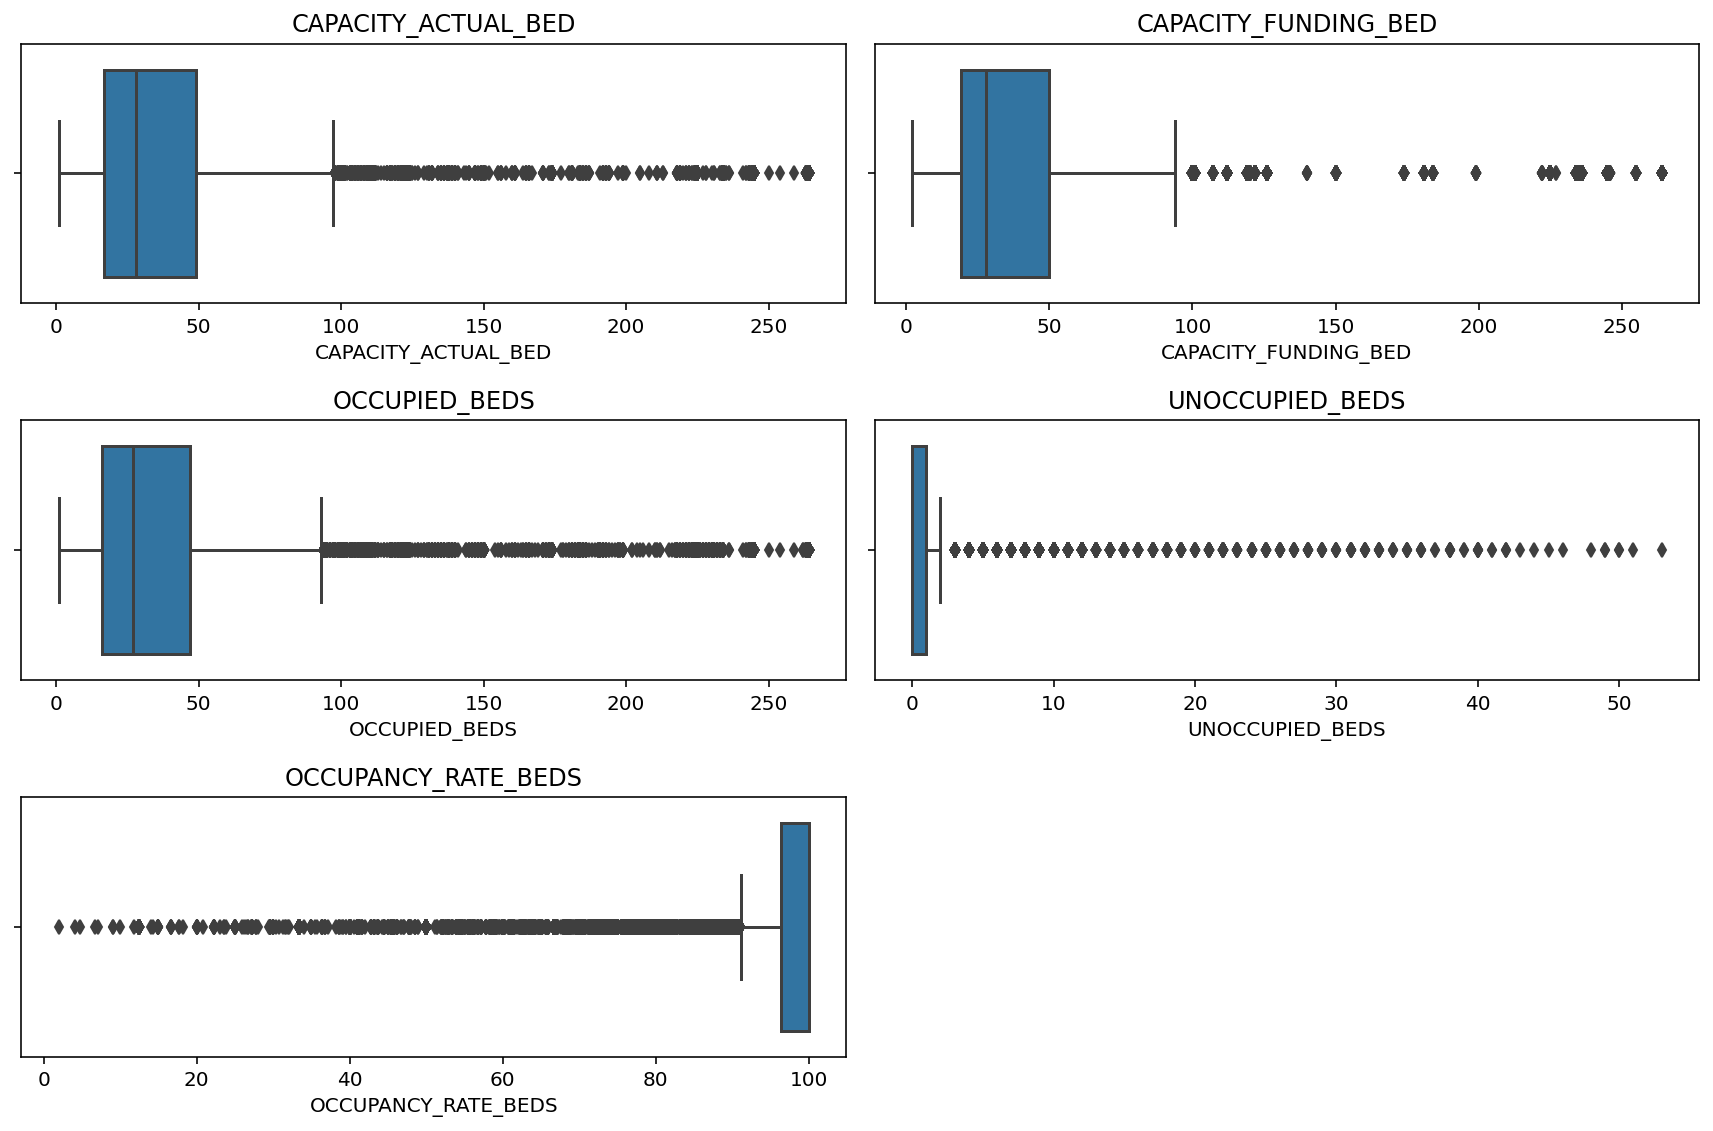

In [17]:
columns_of_interest = [
    'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED',
    'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'OCCUPANCY_RATE_BEDS'
]

plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=df_c[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [18]:
# Calculate Z-scores for the columns of interest
z_scores = zscore(df_c[columns_of_interest])

# Consider data points with an absolute Z-score greater than 3 as outliers
outliers = (np.abs(z_scores) > 3).any(axis=1)

# Filter out the outliers
df_c_no_outliers = df_c[~outliers]

# Check the results
print(f"Original data rows: {df_c.shape[0]}, After removing outliers: {df_c_no_outliers.shape[0]}")


Original data rows: 97403, After removing outliers: 92250


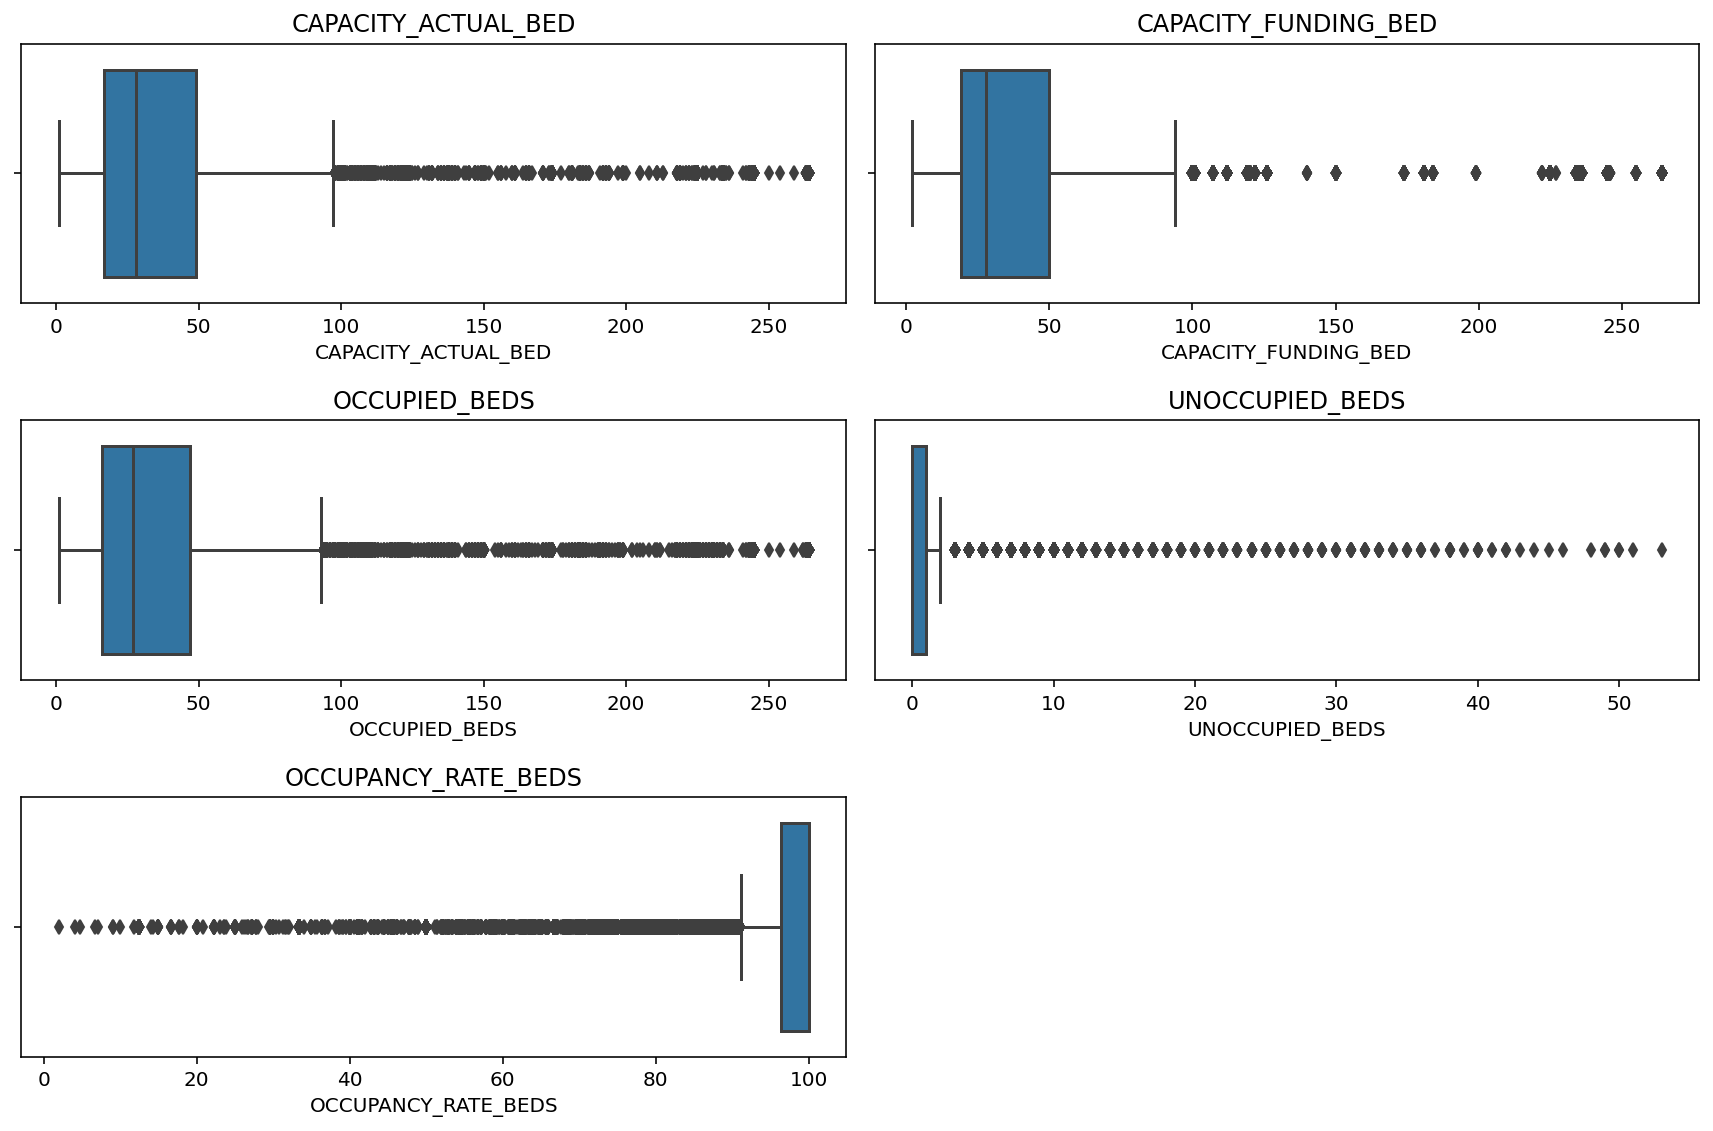

In [19]:
columns_of_interest = [
    'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED',
    'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'OCCUPANCY_RATE_BEDS'
]


plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=df_c[column])
    plt.title(column)

plt.tight_layout()
plt.show()




In [20]:
df_c_no_outliers.head(10)


,OVERNIGHT_SERVICE_TYPE,CAPACITY_TYPE,PROGRAM_MODEL,CAPACITY_ACTUAL_BED,CAPACITY_FUNDING_BED,OCCUPIED_BEDS,UNOCCUPIED_BEDS,OCCUPANCY_RATE_BEDS,LOCATION_ID,LOCATION_NAME
2,Shelter,Bed Based Capacity,Emergency,8.0,8.0,8.0,0.0,100.00,1051.0,COSTI Reception Centre
7,Shelter,Bed Based Capacity,Emergency,42.0,42.0,42.0,0.0,100.00,1029.0,CONC Men's Shelter Lansdowne Ave
8,Shelter,Bed Based Capacity,Emergency,30.0,30.0,30.0,0.0,100.00,1102.0,CONC Men's Shelter Bloor St W
9,Warming Centre,Bed Based Capacity,Emergency,23.0,23.0,19.0,4.0,82.61,1541.0,Christie Ossington - Spadina Rd
16,Shelter,Bed Based Capacity,Transitional,18.0,18.0,14.0,4.0,77.78,1009.0,SSHA Downsview Dells
18,Shelter,Room Based Capacity,Emergency,7.0,20.0,5.0,1.0,83.33,1065.0,SSHA Family Residence
21,Shelter,Bed Based Capacity,Transitional,68.0,68.0,61.0,7.0,89.71,1011.0,SSHA Fort York Residence
23,Shelter,Bed Based Capacity,Transitional,48.0,48.0,46.0,2.0,95.83,1011.0,SSHA Fort York Residence
24,Shelter,Bed Based Capacity,Emergency,101.0,101.0,101.0,0.0,100.00,1360.0,Progress Avenue Shelter
29,Shelter,Bed Based Capacity,Transitional,93.0,93.0,93.0,0.0,100.00,1151.0,SSHA Scarborough Village Residence


In [21]:
df_f = df_c_no_outliers 


Making our target variable normally distributed often will lead to better results

If our target is not normally distributed, we can apply a transformation to it and then fit our regression to predict the transformed values.

How can we tell if our target is normally distributed? There are two ways:

* Using a Visual approach
* Using a Statistical Test

Using a Visual Approach, Plotting a histogram:

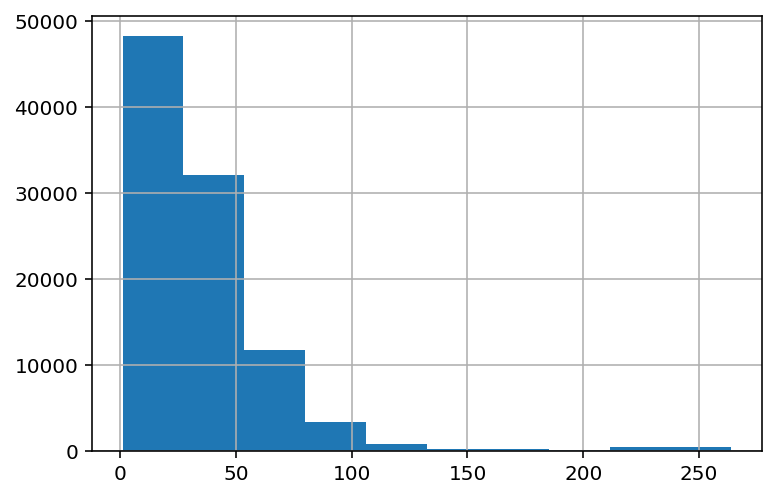

In [22]:
df_c.CAPACITY_ACTUAL_BED.hist();

<AxesSubplot:>

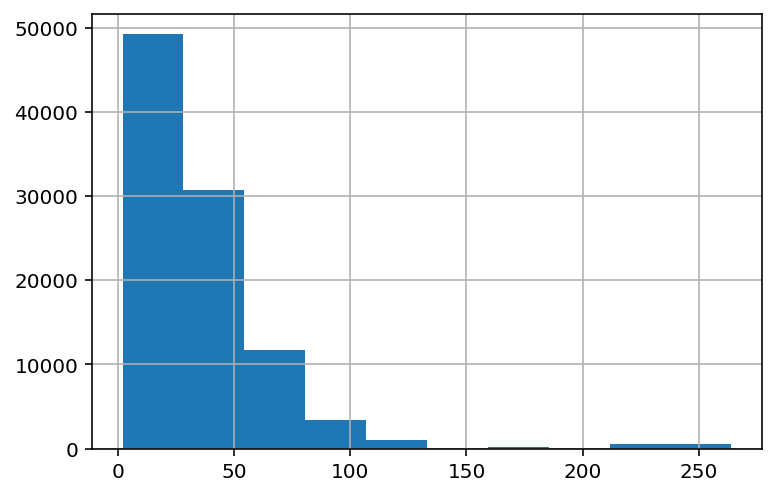

In [23]:
df_c.CAPACITY_FUNDING_BED.hist()

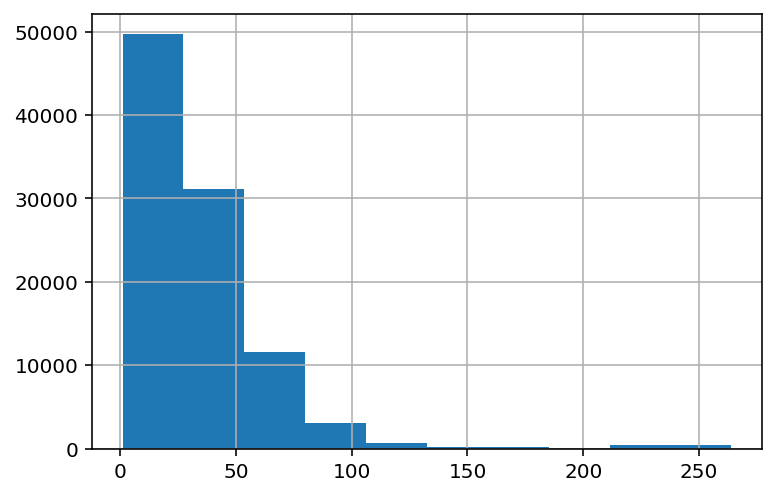

In [24]:
df_c.OCCUPIED_BEDS.hist();

<AxesSubplot:>

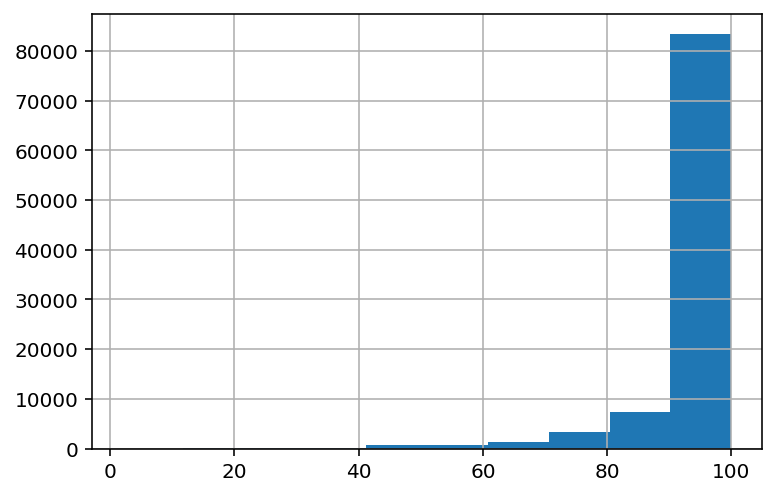

In [25]:
df_c.OCCUPANCY_RATE_BEDS.hist()

<AxesSubplot:>

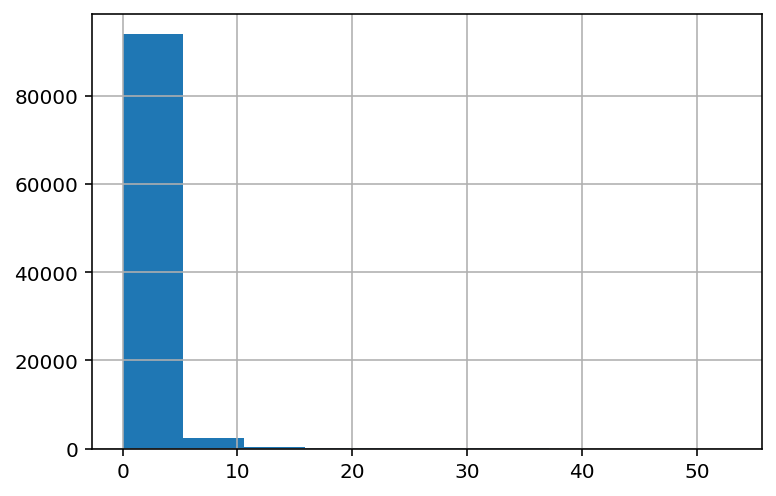

In [26]:
df_c.UNOCCUPIED_BEDS.hist()

#### Using a Statistical Test

Without getting into Bayesian vs. frequentist debates, for the purposes of this lesson, the following will suffice:

* This is a statistical test that tests whether a distribution is normally distributed or not. It isn't perfect, but suffice it to say: 
    * This test outputs a **p-value**. The _higher_ this p-value is the _closer_ the distribution is to normal.
    * Frequentist statisticians would say that you accept that the distribution is normal (more specifically: fail to reject the null hypothesis that it is normal) if p > 0.05.


In [27]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test

In [28]:
normaltest(df_c.CAPACITY_ACTUAL_BED.values)


NormaltestResult(statistic=68800.34524842743, pvalue=0.0)

In [29]:
normaltest(df_c.CAPACITY_FUNDING_BED.values)


NormaltestResult(statistic=69808.14694459896, pvalue=0.0)

In [30]:
normaltest(df_c.OCCUPIED_BEDS.values)


NormaltestResult(statistic=68934.15799487555, pvalue=0.0)

In [31]:
normaltest(df_c.OCCUPANCY_RATE_BEDS.values)


NormaltestResult(statistic=71828.58849825658, pvalue=0.0)

In [32]:
normaltest(df_c.UNOCCUPIED_BEDS.values)

NormaltestResult(statistic=121641.92475821234, pvalue=0.0)

p-value is _extremely_ low. Our **y** variable which we have been dealing with this whole time was not normally distributed!


### Apply transformations to make target variable more normally distributed for Regression


Linear Regression assumes a normally distributed residuals which can be aided by transforming **y** variable which is the target variable. Let's try some common transformations to try and get **y** to be normally distributed: 

* Log Transformation
* Square root Transformation
* Box cox Transformation


### Log Transformation


The log transformation can transform data that is significantly skewed right to be more normally distributed:


Example below

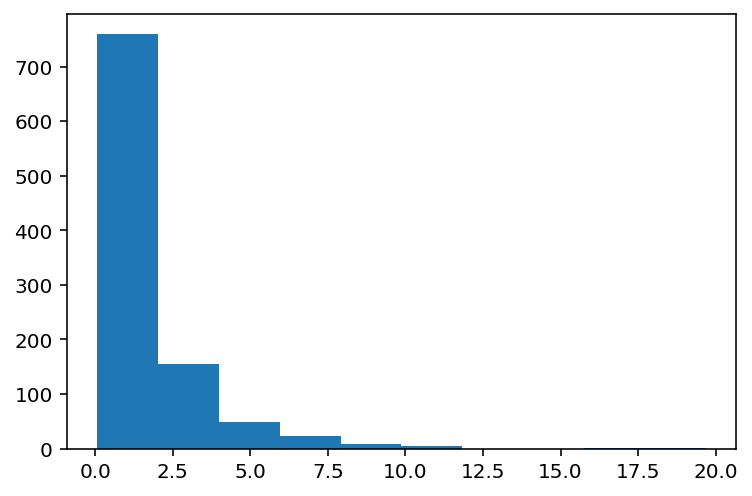

In [33]:
data = plot_exponential_data()

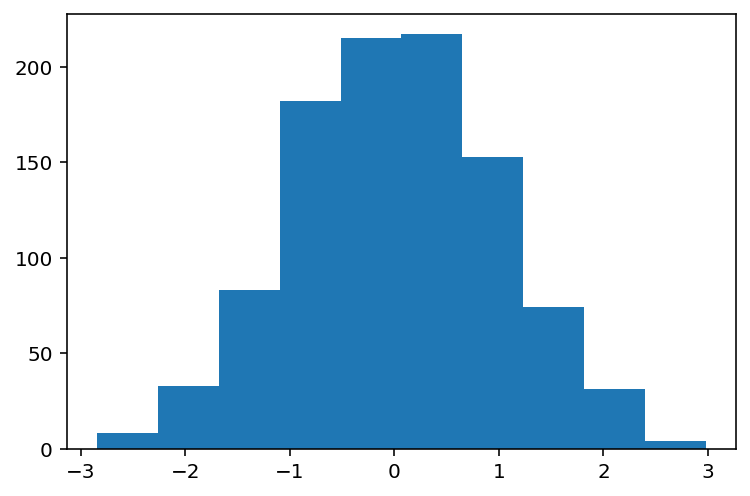

In [34]:
plt.hist(np.log(data));

NormaltestResult(statistic=114672.35101050032, pvalue=0.0)

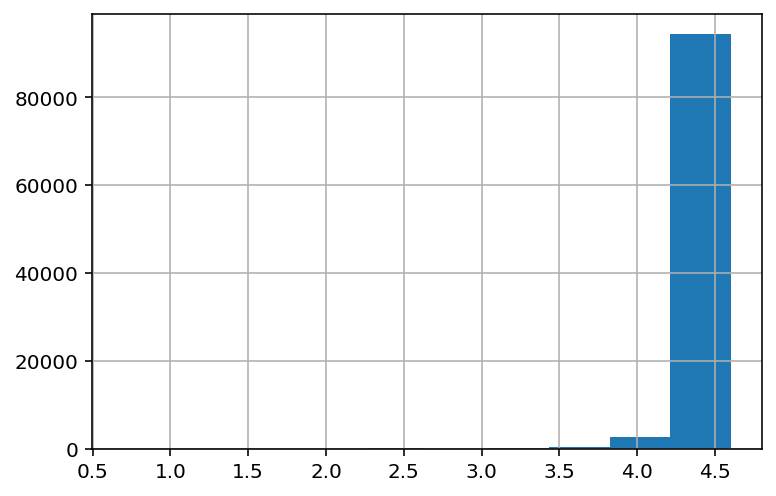

In [35]:
log_O_R_B = np.log(df_c.OCCUPANCY_RATE_BEDS)
log_O_R_B.hist()
normaltest(log_O_R_B)

Conclusion: The output is closer to normal distribution, but still not completely normal.


### Square root Transformation

The square root transformation is another transformation that can transform non-normally distributed data into normally distributed data:


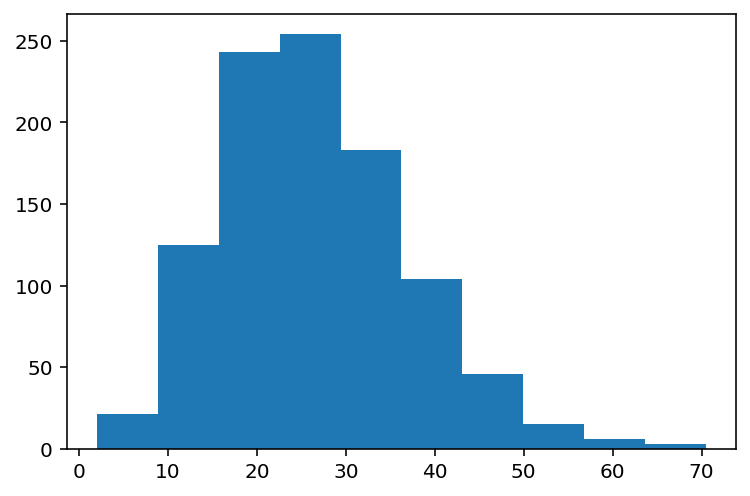

In [36]:
data = plot_square_normal_data()

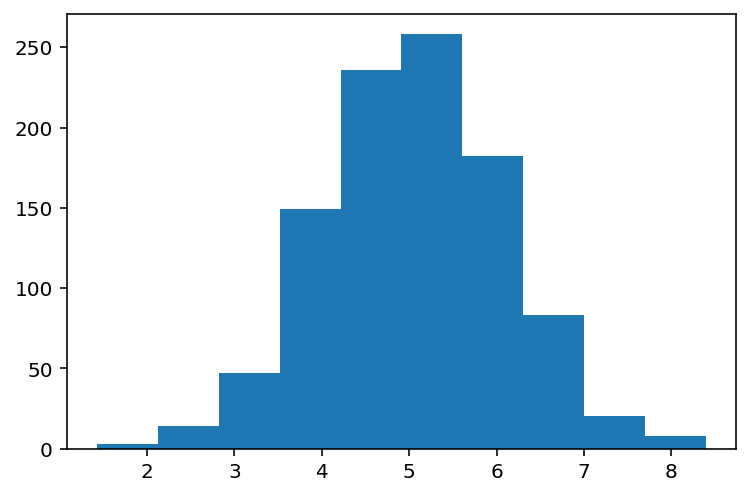

In [37]:
plt.hist(np.sqrt(data));

Apply the square root transformation to the Shelter data target and test whether the result is normally distributed.


### Box cox Transformation


The box cox transformation is a parametrized transformation that tries to get distributions "as close to a normal distribution as possible".

It is defined as:

$$ \text{boxcox}(y_i) = \frac{y_i^{\lambda} - 1}{\lambda} $$

You can think of as a generalization of the square root function: the square root function uses the exponent of 0.5, but box cox lets its exponent vary so it can find the best one.


In [38]:
from scipy.stats import boxcox

In [39]:
bc_result = boxcox(df_c.OCCUPANCY_RATE_BEDS)
boxcox__O_R_B = bc_result[0]
lam = bc_result[1]

In [40]:
lam

15.548180766322634

In [41]:
normaltest(boxcox__O_R_B)

NormaltestResult(statistic=16182.707574769094, pvalue=0.0)

# Unsupervised Model (K-Means Clustering)

Step 1: Data Preprocessing
Select Relevant Features: Choose the features relevant to your analysis. For clustering shelters based on capacity and occupancy, you might select 'CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED',
'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'OCCUPANCY_RATE_BEDS'.

Handle Missing Values: Ensure that missing values are handled, either by filling them with a suitable value (like the mean or median) or by excluding rows with missing values.

Standardize the Data: K-Means is sensitive to the scale of the data, so it's important to standardize the features to have a mean of 0 and a standard deviation of 1.

In [42]:

# Assuming `df` is your DataFrame after filtering for 'Toronto' and relevant columns
features = df[['CAPACITY_ACTUAL_BED','CAPACITY_FUNDING_BED','OCCUPIED_BEDS','UNOCCUPIED_BEDS', 'OCCUPANCY_RATE_BEDS']].dropna()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


Step 2: Choosing the Number of Clusters (k)
Elbow Method: Use the Elbow method to determine the optimal number of clusters by fitting the K-Means model with a range of k values and plotting the sum of squared distances (inertia) for each.

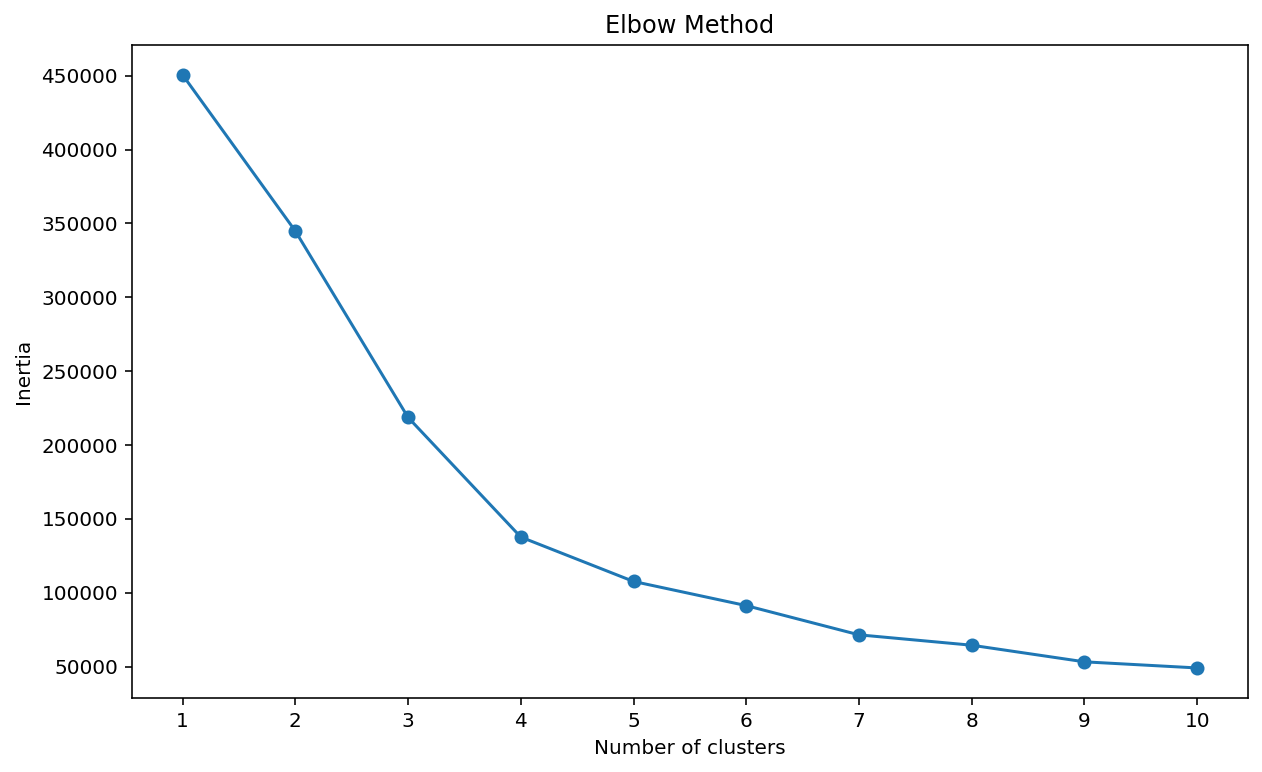

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 11)  # Example range, adjust based on your dataset
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.show()


Step 3: Applying K-Means Clustering
Fit the Model: Choose the k from the Elbow method and fit the K-Means model to your standardized data

In [50]:


# Assuming df_c is your DataFrame after preprocessing

# Step 1: Prepare your features for clustering
# Selecting relevant features for clustering
features = df_c[['CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'OCCUPANCY_RATE_BEDS']]

# Step 2: Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert scaled features back to DataFrame for alignment
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=df_c.index)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(features_scaled_df)

# Step 4: Assign the clusters back to the original DataFrame
df_c['cluster'] = kmeans.labels_

# Now df_c has a new column 'cluster' with cluster labels
print(df_c.head())


   OVERNIGHT_SERVICE_TYPE       CAPACITY_TYPE PROGRAM_MODEL  \
2                 Shelter  Bed Based Capacity     Emergency   
7                 Shelter  Bed Based Capacity     Emergency   
8                 Shelter  Bed Based Capacity     Emergency   
9          Warming Centre  Bed Based Capacity     Emergency   
16                Shelter  Bed Based Capacity  Transitional   

    CAPACITY_ACTUAL_BED  CAPACITY_FUNDING_BED  OCCUPIED_BEDS  UNOCCUPIED_BEDS  \
2                   8.0                   8.0            8.0              0.0   
7                  42.0                  42.0           42.0              0.0   
8                  30.0                  30.0           30.0              0.0   
9                  23.0                  23.0           19.0              4.0   
16                 18.0                  18.0           14.0              4.0   

    OCCUPANCY_RATE_BEDS  LOCATION_ID                     LOCATION_NAME  \
2                100.00       1051.0            COSTI Recept

Step 3: Analyze Cluster Characteristics
To understand the characteristics of each cluster, you can examine the mean values of the features within each cluster.

In [51]:
# Calculate mean values of features within each cluster
cluster_means = df_c.groupby('cluster')[['CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'OCCUPANCY_RATE_BEDS']].mean()
print(cluster_means)


         CAPACITY_ACTUAL_BED  CAPACITY_FUNDING_BED  OCCUPIED_BEDS  \
cluster                                                             
0                  46.700331             47.976821      30.840232   
1                  61.250122             63.233882      60.722451   
2                 215.436631            228.073416     214.525502   
3                  16.871650             18.941503      13.632108   
4                  22.056924             23.232420      21.822114   

         UNOCCUPIED_BEDS  OCCUPANCY_RATE_BEDS  
cluster                                        
0              15.860099            59.755240  
1               0.527671            99.121783  
2               0.911128            99.541167  
3               3.146078            77.574604  
4               0.234810            98.984937  


Step 4: Visualization
Visualizing the clusters can provide insights into how they are separated based on the scaled features. You can use pair plots or scatter plots for this purpose.

Using scatterplot

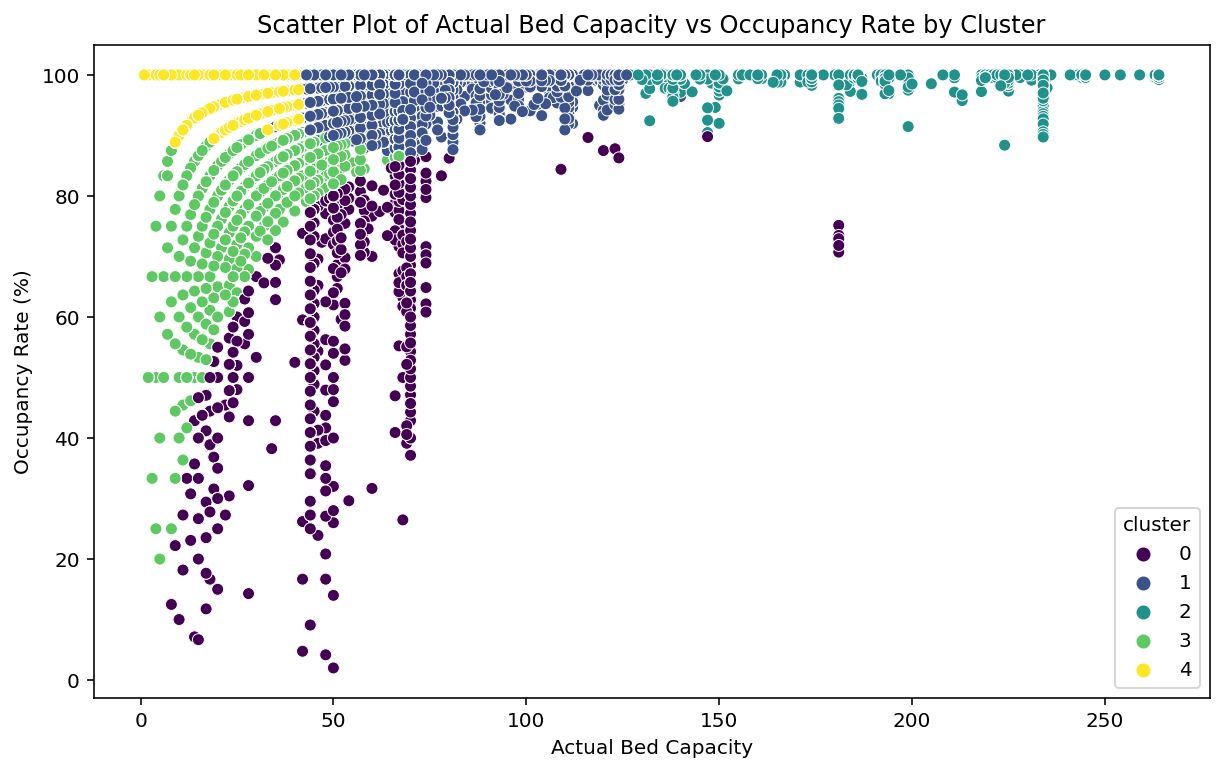

In [52]:
# Example scatter plot for two features
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_c, x='CAPACITY_ACTUAL_BED', y='OCCUPANCY_RATE_BEDS', hue='cluster', palette='viridis')
plt.title('Scatter Plot of Actual Bed Capacity vs Occupancy Rate by Cluster')
plt.xlabel('Actual Bed Capacity')
plt.ylabel('Occupancy Rate (%)')
plt.show()
